## Portfolio


In [8]:
# import os
# import re
# from PIL import Image
# import shutil

# # Root directory (current working directory)
# root_dir = "."

# # Function to check image resolution
# def check_image_resolution(img_path):
#     try:
#         with Image.open(img_path) as img:
#             width, height = img.size
#             print(f"{img_path}: {width}x{height} pixels")
#             return width, height
#     except Exception as e:
#         print(f"Error processing {img_path}: {e}")
#         return None, None

# # Function to rename image files in sequential order
# def rename_images_in_order(directory):
#     # List of common image extensions
#     image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')
    
#     # Get all image files in the directory
#     image_files = []
#     for dirpath, dirnames, filenames in os.walk(directory):
#         for filename in filenames:
#             if filename.lower().endswith(image_extensions):
#                 img_path = os.path.join(dirpath, filename)
#                 image_files.append(img_path)
    
#     # Sort image files by their current names
#     image_files.sort()
    
#     # Rename files in order
#     image_count = 0
#     for i, old_path in enumerate(image_files, 1):
#         # Get directory, extension and base name
#         directory = os.path.dirname(old_path)
#         _, ext = os.path.splitext(old_path)
        
#         # Create new filename with sequential number
#         new_filename = f"image_{i:03d}{ext}"
#         new_path = os.path.join(directory, new_filename)
        
#         try:
#             # Rename the file
#             shutil.move(old_path, new_path)
#             width, height = check_image_resolution(new_path)
#             if width and height:
#                 print(f"Renamed: {old_path} -> {new_path} ({width}x{height} pixels)")
#             else:
#                 print(f"Renamed: {old_path} -> {new_path}")
#             image_count += 1
#         except Exception as e:
#             print(f"Error renaming {old_path}: {e}")
    
#     return image_count

# # Rename images in sequential order
# image_count = rename_images_in_order(root_dir)

# if image_count == 0:
#     print("No image files found in the directory tree.")
# else:
#     print(f"Total images processed and renamed: {image_count}")


`Image 1`

In [2]:
!pip install pillow numpy opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import os
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import cv2
from matplotlib import pyplot as plt

def enhance_image(input_path, output_path=None, blur_radius=2, contrast=1.2, brightness=1.1, 
                 saturation=1.3, vibrance=1.2, show_before_after=False):
    """
    Enhances an image with color grading and Gaussian smoothing
    
    Args:
        input_path: Path to input image
        output_path: Path to save enhanced image (if None, will use input_path + '_enhanced')
        blur_radius: Radius for Gaussian blur (default 2)
        contrast: Contrast adjustment factor (default 1.2)
        brightness: Brightness adjustment factor (default 1.1)
        saturation: Saturation adjustment factor (default 1.3)
        vibrance: Vibrance adjustment factor (default 1.2)
        show_before_after: Whether to display before/after comparison
    """
    try:
        # Open the image
        img = Image.open(input_path)
        
        # Save original for comparison
        original = img.copy()
        
        # Step 1: Apply Gaussian blur to reduce noise
        img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        
        # Step 2: Enhance basic properties
        img = ImageEnhance.Contrast(img).enhance(contrast)
        img = ImageEnhance.Brightness(img).enhance(brightness)
        img = ImageEnhance.Color(img).enhance(saturation)
        
        # Step 3: Convert to OpenCV format for additional processing
        img_cv = np.array(img)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
        
        # Step 4: Apply advanced color grading using curves
        # Create a LUT for color grading (simple S-curve)
        lookUpTable = np.empty((1, 256), np.uint8)
        for i in range(256):
            # Apply S-curve to increase contrast in midtones
            lookUpTable[0, i] = np.clip(255 * (1 / (1 + np.exp(-0.05 * (i - 128)))) * 0.8, 0, 255)
        
        # Apply the LUT to the blue, green, and red channels
        blue, green, red = cv2.split(img_cv)
        red = cv2.LUT(red, lookUpTable)
        green = cv2.LUT(green, lookUpTable)
        blue = cv2.LUT(blue, lookUpTable)
        
        # Combine the enhanced channels
        img_cv = cv2.merge([blue, green, red])
        
        # Step 5: Convert back to PIL format
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img_cv)
        
        # Step 6: Apply final touches
        img = ImageEnhance.Sharpness(img).enhance(1.5)  # Sharpen after blur for defined edges
        
        # Create output path if not provided
        if output_path is None:
            file_name, ext = os.path.splitext(input_path)
            output_path = f"{file_name}_enhanced{ext}"
        
        # Save the enhanced image
        img.save(output_path)
        print(f"Enhanced image saved to {output_path}")
        
        # Show before and after if requested
        if show_before_after:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Original")
            plt.imshow(original)
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title("Enhanced")
            plt.imshow(img)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
        return output_path
        
    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        return None

def enhance_all_images(directory=".", output_dir=None, image_extensions=('.png', '.jpg', '.jpeg')):
    """
    Enhances all images in a directory
    
    Args:
        directory: Directory containing images
        output_dir: Directory to save enhanced images (if None, will save alongside originals)
        image_extensions: Tuple of image extensions to process
    """
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Get all image files in the directory
    image_files = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(image_extensions):
                img_path = os.path.join(dirpath, filename)
                image_files.append(img_path)
    
    enhanced_count = 0
    for img_path in image_files:
        if output_dir:
            file_name = os.path.basename(img_path)
            output_path = os.path.join(output_dir, f"enhanced_{file_name}")
        else:
            output_path = None  # Will create path with _enhanced suffix
            
        result = enhance_image(img_path, output_path)
        if result:
            enhanced_count += 1
            
    print(f"Enhanced {enhanced_count} of {len(image_files)} images")



In [11]:
enhance_all_images('.', output_dir='enhanced1')

Enhanced image saved to enhanced1/enhanced_image_009.jpg
Enhanced image saved to enhanced1/enhanced_image_008.jpg
Enhanced image saved to enhanced1/enhanced_image_005.jpg
Enhanced image saved to enhanced1/enhanced_image_011.jpg
Enhanced image saved to enhanced1/enhanced_image_010.jpg
Enhanced image saved to enhanced1/enhanced_image_004.jpg
Enhanced image saved to enhanced1/enhanced_image_006.jpg
Enhanced image saved to enhanced1/enhanced_image_007.jpg
Enhanced image saved to enhanced1/enhanced_image_003.jpg
Enhanced image saved to enhanced1/enhanced_image_002.jpg
Enhanced image saved to enhanced1/enhanced_image_001.jpg
Enhanced 11 of 11 images


In [10]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_before_after_comparison(directory=".", enhanced_dir="enhanced1", processed_dir="processed_images", target_images=["image_001", "image_009", "image_011"]):
    """
    Display before and after comparison of original and enhanced images
    
    Args:
        directory: Directory containing original images
        enhanced_dir: Directory containing enhanced images
        processed_dir: Directory to store processed images
        target_images: List of specific image base names to display
    """
    # Create processed_images directory if it doesn't exist
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)
        
    # Get all image files in the directory
    image_files = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Skip already enhanced images
                if not filename.startswith("enhanced_"):
                    # Check if this is one of our target images
                    if any(target in filename for target in target_images):
                        img_path = os.path.join(dirpath, filename)
                        enhanced_path = os.path.join(enhanced_dir, f"enhanced_{filename}")
                        
                        # Only include if both original and enhanced versions exist
                        if os.path.exists(enhanced_path):
                            image_files.append((img_path, enhanced_path, filename))
    
    num_images = len(image_files)
    
    if num_images == 0:
        print("No matching image pairs found!")
        return
    
    # Create a figure with 2 rows (original and enhanced) and columns for each image
    fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 6))
    
    # If only one image, axes won't be 2D
    if num_images == 1:
        axes = axes.reshape(2, 1)
    
    for i, (original_path, enhanced_path, filename) in enumerate(image_files):
        # Load images
        original_img = Image.open(original_path)
        enhanced_img = Image.open(enhanced_path)
        
        # Display original images in the first row
        axes[0, i].imshow(np.array(original_img))
        axes[0, i].set_title(f"Original:")
        axes[0, i].axis('off')
        
        # Display enhanced images in the second row
        axes[1, i].imshow(np.array(enhanced_img))
        axes[1, i].set_title(f"Enhanced:")
        axes[1, i].axis('off')
        
        # Extract base name without extension
        base_name = os.path.splitext(filename)[0]
        # Save the enhanced image to processed_images directory
        processed_path = os.path.join(processed_dir, f"{base_name}_process_1{os.path.splitext(filename)[1]}")
        enhanced_img.save(processed_path)
    
    plt.tight_layout()
    plt.show()
    
# Display comparison of only the specified images
display_before_after_comparison()


No matching image pairs found!


In [42]:
import os
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt

def process_image_combination2(input_path, output_path=None, bilateral_d=9, bilateral_sigma_color=75, bilateral_sigma_space=75, blur_strength=20, show_before_after=False):
    """
    Enhances an image with white balancing (Grey World), bilateral filtering, and tilt-shift effect
    
    Args:
        input_path: Path to input image
        output_path: Path to save enhanced image (if None, will use input_path + '_processed2')
        bilateral_d: Diameter of each pixel neighborhood for bilateral filter
        bilateral_sigma_color: Filter sigma in the color space
        bilateral_sigma_space: Filter sigma in the coordinate space
        blur_strength: Strength of the blur effect for tilt-shift
        show_before_after: Whether to display before/after comparison
    """
    try:
        # Open the image
        img = Image.open(input_path)
        
        # Save original for comparison
        original = img.copy()
        
        # Convert to OpenCV format for processing
        img_cv = np.array(img)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
        
        # Step 1: Apply Grey World white balancing
        # Calculate the average values for each channel
        b_avg, g_avg, r_avg = cv2.mean(img_cv)[:3]
        
        # Calculate the average of the averages
        avg = (b_avg + g_avg + r_avg) / 3
        
        # Scale the channels to balance them - add epsilon to avoid division by zero
        epsilon = 1e-5
        b, g, r = cv2.split(img_cv)
        b = np.clip(b * (avg / (b_avg + epsilon)), 0, 255).astype(np.uint8)
        g = np.clip(g * (avg / (g_avg + epsilon)), 0, 255).astype(np.uint8)
        r = np.clip(r * (avg / (r_avg + epsilon)), 0, 255).astype(np.uint8)
        
        # Merge the balanced channels
        img_cv = cv2.merge([b, g, r])
        
        # Step 2: Apply bilateral filtering to smooth while preserving edges
        img_cv = cv2.bilateralFilter(img_cv, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)
        
        # Step 3: Apply tilt-shift effect
        height, width = img_cv.shape[:2]

        # Create a blurred version of the image
        blurred = cv2.GaussianBlur(img_cv, (0, 0), sigmaX=blur_strength, sigmaY=blur_strength)

        # Create a mask to divide the image into three rows
        mask = np.zeros((height, 1), dtype=np.float32)

        # Define the height of each row
        row_height = height // 3
        transition_height = row_height // 2

        for y in range(height):
            if y < row_height - transition_height:  # Top row (blurred)
                mask[y] = 1.0
            elif y < row_height + transition_height:  # Transition from blurred to clear
                mask[y] = (row_height + transition_height - y) / (2 * transition_height)
            elif y < 2 * row_height - transition_height:  # Middle row (clear)
                mask[y] = 0.0
            elif y < 2 * row_height + transition_height:  # Transition from clear to blurred
                mask[y] = (y - (2 * row_height - transition_height)) / (2 * transition_height)
            else:  # Bottom row (blurred)
                mask[y] = 1.0

        mask = np.repeat(mask, width, axis=1)
        mask = cv2.merge([mask, mask, mask])

        # Blend images using the mask
        img_cv = (img_cv * (1 - mask) + blurred * mask).astype(np.uint8)
        
        # Convert back to PIL format
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img_cv)
        
        # Create output path if not provided
        if output_path is None:
            file_name, ext = os.path.splitext(input_path)
            output_path = f"{file_name}_processed2{ext}"
        
        # Save the processed image
        img.save(output_path)
        print(f"Processed image saved to {output_path}")
        
        # Show before and after if requested
        if show_before_after:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Original")
            plt.imshow(original)
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title("Processed (White Balance + Bilateral + Tilt-Shift)")
            plt.imshow(img)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
        return output_path
        
    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        return None

def process_specific_images(image_list, output_dir=None, bilateral_d=9, bilateral_sigma_color=75, bilateral_sigma_space=75, blur_strength=10, show_last_comparison=False):
    """
    Processes only the specified list of images
    
    Args:
        image_list: List of image filenames to process
        output_dir: Directory to save processed images (if None, will save alongside originals)
        bilateral_d: Diameter of each pixel neighborhood for bilateral filter
        bilateral_sigma_color: Filter sigma in the color space
        bilateral_sigma_space: Filter sigma in the coordinate space
        blur_strength: Strength of the blur effect for tilt-shift
        show_last_comparison: Whether to display before/after comparison for the last image
    """
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    processed_count = 0
    for i, img_name in enumerate(image_list):
        # Determine if this is the last image (for showing comparison)
        is_last = (i == len(image_list) - 1)
        
        if output_dir:
            output_path = os.path.join(output_dir, f"enhanced_{img_name}")
        else:
            output_path = None  # Will create path with _processed2 suffix
        
        # Process the image
        result = process_image_combination2(
            img_name, 
            output_path, 
            bilateral_d, 
            bilateral_sigma_color, 
            bilateral_sigma_space,
            blur_strength,
            show_before_after=(show_last_comparison and is_last)
        )
        
        if result:
            processed_count += 1
    
    print(f"Processed {processed_count} of {len(image_list)} specified images")

In [45]:
# List of images to process
image_files = [
    "image_001.jpg", 
    "image_008.jpg", "image_009.jpg", 
    #  "image_011.jpg"
]

# Example usage:
process_specific_images(image_files, output_dir="enhanced2")

Processed image saved to enhanced2/enhanced_image_001.jpg
Processed image saved to enhanced2/enhanced_image_008.jpg
Processed image saved to enhanced2/enhanced_image_009.jpg
Processed 3 of 3 specified images


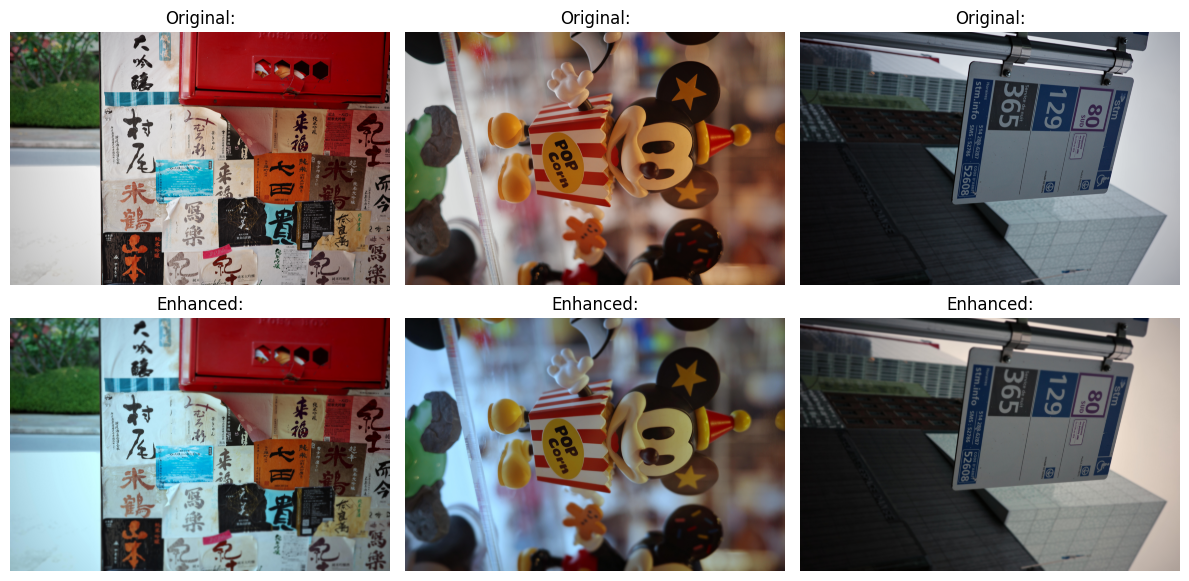

In [46]:
#display before and after comparison
display_before_after_comparison('.', "enhanced2", "processed_images", image_files)

In [65]:
import os
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from scipy.ndimage import convolve

def process_combination7(input_path, output_path=None, bokeh_radius=30, 
                         bokeh_threshold=200, show_before_after=False):
    """
    Enhances an image with Color Inversion (Negative) and Bokeh Simulation
    
    Args:
        input_path: Path to input image
        output_path: Path to save enhanced image (if None, will use input_path + '_combo7')
        bokeh_radius: Radius of the bokeh blur effect
        bokeh_threshold: Threshold to determine foreground/background for bokeh effect
        show_before_after: Whether to display before/after comparison
    """
    try:
        # Open the image
        img = Image.open(input_path)
        original = img.copy()
        
        # Convert to OpenCV format
        img_cv = np.array(img)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
        
        # Step 1: Apply Color Inversion (negative)
        # Invert each channel (255 - pixel value)
        b, g, r = cv2.split(img_cv)
        b_inv = 255 - b
        g_inv = 255 - g
        r_inv = 255 - r
        
        # Merge the inverted channels
        img_inverted = cv2.merge([b_inv, g_inv, r_inv])
        
        # Step 2: Apply Bokeh Simulation
        # Create a simple depth map based on darkness (inverted from original approach)
        gray = cv2.cvtColor(img_inverted, cv2.COLOR_BGR2GRAY)
        # Invert the threshold logic - now dark areas are foreground
        _, depth_map = cv2.threshold(gray, 255 - bokeh_threshold, 255, cv2.THRESH_BINARY)
        
        # Create aperture-shaped kernel for bokeh effect (hexagonal shape is common)
        bokeh_kernel = create_hexagonal_kernel(bokeh_radius)
        
        # Apply the bokeh blur to the entire image
        blurred_r = cv2.filter2D(r_inv, -1, bokeh_kernel)
        blurred_g = cv2.filter2D(g_inv, -1, bokeh_kernel)
        blurred_b = cv2.filter2D(b_inv, -1, bokeh_kernel)
        blurred = cv2.merge([blurred_b, blurred_g, blurred_r])
        
        # Combine original foreground with blurred background using the depth map
        depth_map_3ch = cv2.merge([depth_map, depth_map, depth_map]) / 255.0
        img_bokeh = img_inverted * depth_map_3ch + blurred * (1 - depth_map_3ch)
        img_bokeh = img_bokeh.astype(np.uint8)
        
        # Convert back to PIL format
        img_final = cv2.cvtColor(img_bokeh, cv2.COLOR_BGR2RGB)
        img_final = Image.fromarray(img_final)
        
        # Create output path if not provided
        if output_path is None:
            file_name, ext = os.path.splitext(input_path)
            output_path = f"{file_name}_combo7{ext}"
        
        # Save the enhanced image
        img_final.save(output_path)
        print(f"Enhanced image saved to {output_path}")
        
        # Show before and after if requested
        if show_before_after:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Original")
            plt.imshow(original)
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title("Enhanced (Inverted + Bokeh)")
            plt.imshow(img_final)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
        return output_path
        
    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        return None

def create_hexagonal_kernel(radius):
    """Creates a hexagonal kernel for bokeh simulation"""
    size = radius * 2 + 1
    kernel = np.zeros((size, size))
    center = radius
    
    # Create a hexagonal shape
    for y in range(size):
        for x in range(size):
            # Calculate distance from center
            dx = x - center
            dy = y - center
            dist = np.sqrt(dx*dx + dy*dy)
            
            # Apply hexagonal mask
            if dist <= radius:
                # Add hexagonal shape effect
                angle = np.arctan2(dy, dx) % (np.pi/3)
                factor = np.cos(angle)
                if dist * factor <= radius:
                    kernel[y, x] = 1
    
    # Normalize the kernel
    return kernel / np.sum(kernel)

def process_specific_images_combo7(image_list, output_dir=None, bokeh_radius=30, 
                                  bokeh_threshold=200, show_last_comparison=False):
    """
    Processes specified images with Combination 7: Color Inversion + Bokeh
    
    Args:
        image_list: List of image filenames to process
        output_dir: Directory to save processed images
        bokeh_radius: Radius of the bokeh blur effect
        bokeh_threshold: Threshold to determine foreground/background for bokeh
        show_last_comparison: Whether to display comparison for the last image
    """
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    processed_count = 0
    for i, img_name in enumerate(image_list):
        # Determine if this is the last image (for showing comparison)
        is_last = (i == len(image_list) - 1)
        
        if output_dir:
            output_path = os.path.join(output_dir, f"enhanced_{img_name}")
        else:
            output_path = None  # Will create path with _combo7 suffix
        
        # Process the image
        result = process_combination7(
            img_name, 
            output_path, 
            bokeh_radius=bokeh_radius,
            bokeh_threshold=bokeh_threshold,
            show_before_after=(show_last_comparison and is_last)
        )
        
        if result:
            processed_count += 1
    
    print(f"Processed {processed_count} of {len(image_list)} images with Combination 7")


# Example usage:
# process_specific_images_combo7(
#     image_files, 
#     output_dir="combo7_images", 
#     bokeh_radius=30,
#     bokeh_threshold=200
# )

In [69]:
# List of images to process
image_files = [
    # "image_001.jpg", 
    "image_008.jpg", "image_009.jpg", 
     "image_011.jpg"
]


In [70]:
process_specific_images_combo7(
    image_files, 
    output_dir="combo7_images", 
    bokeh_radius=50,
    bokeh_threshold=200
)

Enhanced image saved to combo7_images/enhanced_image_008.jpg
Enhanced image saved to combo7_images/enhanced_image_009.jpg
Enhanced image saved to combo7_images/enhanced_image_011.jpg
Processed 3 of 3 images with Combination 7


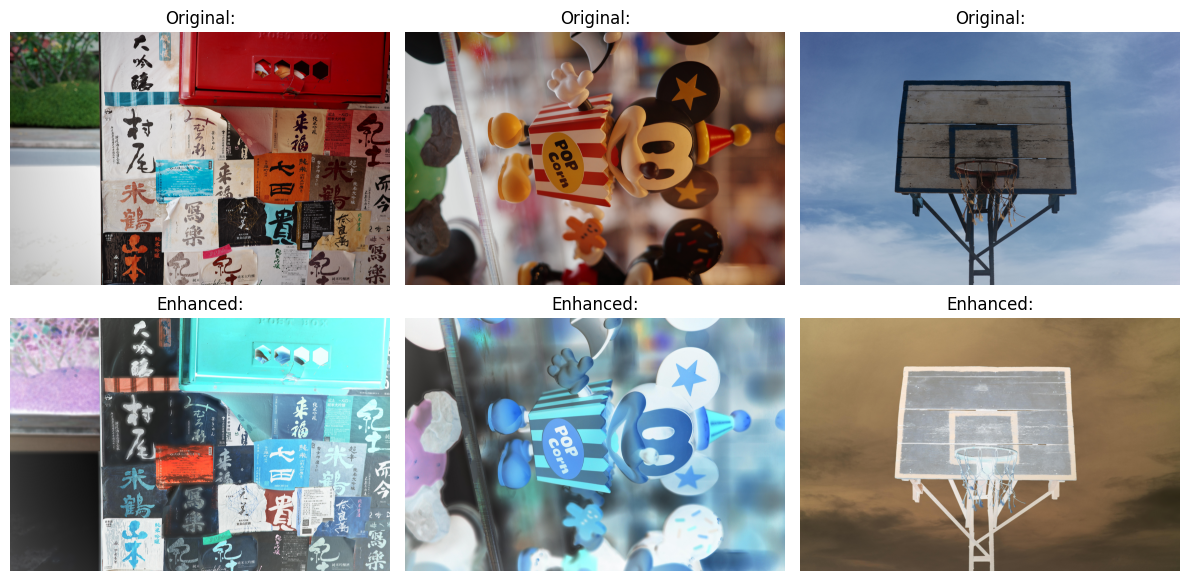

In [71]:
display_before_after_comparison('.', "combo7_images", "processed_images", image_files)

In [6]:
# List of images to process
image_files = [
    "image_001.jpg", 
    "image_008.jpg", "image_009.jpg", 
    #  "image_011.jpg"
]


In [89]:
#reference: https://github.com/bryandlee/animegan2-pytorch
def cartoonize_image(input_path, output_path, model=None, cartoon_strength=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Use provided model or load model
    if model is None:
        print("Loading model from torch.hub...")
        model = torch.hub.load("bryandlee/animegan2-pytorch:main", "generator", pretrained="face_paint_512_v1")
    
    model = model.to(device)
    model.eval()
    
    if device.type == 'cuda':
        model = model.half()
        print("Using half precision for faster processing")
    
    # Standard normalization for AnimeGANv2
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Load and process the image
    img = Image.open(input_path).convert("RGB")
    original_size = img.size
    
    # Convert to tensor
    input_tensor = transform(img)
    original_tensor = input_tensor.clone()  # Keep a copy of the original
    if device.type == 'cuda':
        input_tensor = input_tensor.half()
        original_tensor = original_tensor.half()
    
    # Process image
    with torch.no_grad():  # Disable gradient calculations
        input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension
        output_tensor = model(input_tensor)[0]  # Get first (only) result from batch
        
        # Denormalize
        output_tensor = output_tensor * 0.5 + 0.5
        
        # If cartoon_strength is not 1.0, blend with original
        if cartoon_strength != 1.0:
            # Denormalize original for blending
            original_tensor = original_tensor.to(device) * 0.5 + 0.5
            # Blend: output = cartoon_strength * cartoon + (1-cartoon_strength) * original
            output_tensor = cartoon_strength * output_tensor + (1 - cartoon_strength) * original_tensor
        
        # Convert to PIL and resize back to original
        cartoon = transforms.ToPILImage()(output_tensor.cpu().float().clamp(0, 1))
        cartoon = cartoon.resize(original_size, Image.LANCZOS)
        
        # Save output
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cartoon.save(output_path)
    
    print(f"Cartoonized image saved to {output_path} with strength {cartoon_strength}")
    return output_path


In [90]:
import torch
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [93]:
# Load the model once for efficiency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("bryandlee/animegan2-pytorch:main", "generator", pretrained="face_paint_512_v1")
model = model.to(device)
model.eval()
if device.type == 'cuda':
    model = model.half()
    print("Using half precision for faster processing")

# Process all images in the image_files list
processed_images = []
for img_file in image_files:
    # Create output path in the processed folder
    base_name = os.path.basename(img_file)
    output_path = os.path.join('processed_images', 'enhanced_'+base_name)
    
    # Apply cartoonization
    processed_path = cartoonize_image(img_file, output_path, model=model)
    processed_images.append(processed_path)
    

Using cache found in /Users/bohan/.cache/torch/hub/bryandlee_animegan2-pytorch_main


Cartoonized image saved to processed_images/enhanced_image_001.jpg with strength 1.0
Cartoonized image saved to processed_images/enhanced_image_008.jpg with strength 1.0
Cartoonized image saved to processed_images/enhanced_image_009.jpg with strength 1.0


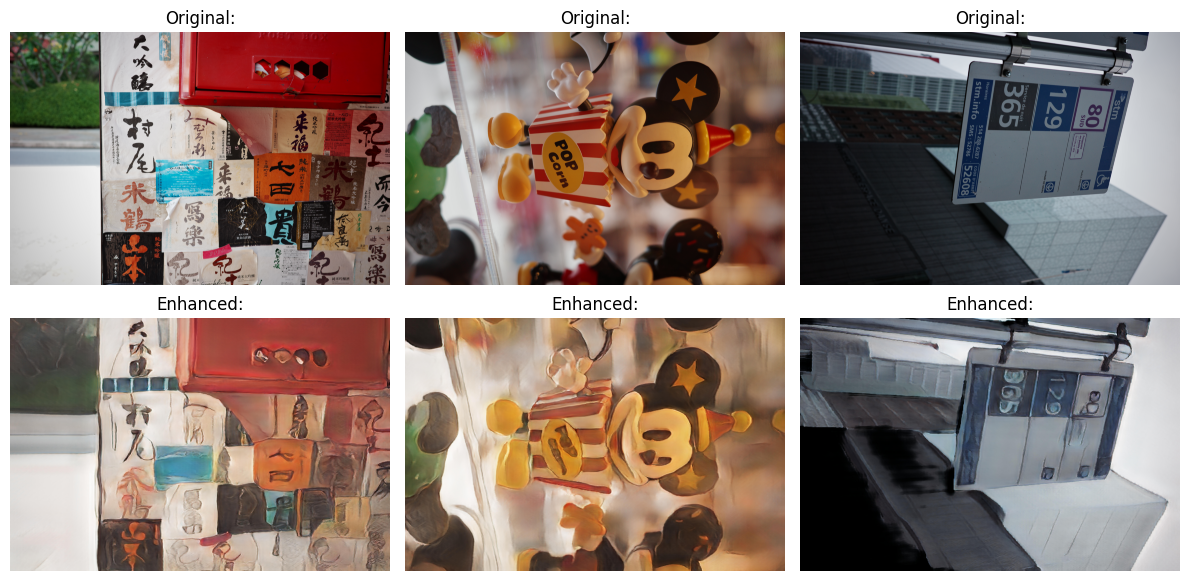

In [95]:
display_before_after_comparison('.', "processed_images", "cartoonized_images", image_files)

In [3]:
import os
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

# Define a simplified CycleGAN Generator (this is a placeholder for a pre-trained model)
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

def process_cyclegan_bilateral_color(input_path, output_path=None, model_path=None, domain="day2night",
                                     bilateral_d=9, bilateral_sigma_color=75, bilateral_sigma_space=75,
                                     color_style="cool", show_before_after=False):
    """
    Apply CycleGAN translation, bilateral filtering, and color grading to an image
    
    Args:
        input_path: Path to input image
        output_path: Path to save enhanced image (if None, will use input_path + '_cyclegan')
        model_path: Path to pre-trained CycleGAN model (if None, will use a placeholder)
        domain: Translation domain ('day2night', 'photo2painting', etc.)
        bilateral_d: Diameter of each pixel neighborhood for bilateral filter
        bilateral_sigma_color: Filter sigma in the color space
        bilateral_sigma_space: Filter sigma in the coordinate space
        color_style: Color grading style ('cool', 'warm', 'film', 'vintage')
        show_before_after: Whether to display before/after comparison
    """
    try:
        # Open the image
        img = Image.open(input_path)
        original = img.copy()
        
        # Step 1: Apply CycleGAN Translation
        # In a real implementation, you would load a pre-trained model
        if model_path:
            # Load pre-trained model weights
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            generator = Generator()
            generator.load_state_dict(torch.load(model_path, map_location=device), strict=False)
            generator.eval()
            
            # Prepare input image for the model
            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            
            # Process image through the CycleGAN
            input_tensor = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                output_tensor = generator(input_tensor)
            
            # Convert output tensor to image
            output = output_tensor.cpu().squeeze(0)
            output = output * 0.5 + 0.5  # Denormalize
            output = transforms.ToPILImage()(output)
            
            # Resize back to original size if necessary
            if output.size != img.size:
                output = output.resize(img.size, Image.BICUBIC)
        else:
            # Placeholder: Apply a simple filter to simulate domain translation
            output = img.copy()
            if domain == "day2night":
                # Simulate night by darkening and adding blue tint
                img_array = np.array(output).astype(float)
                img_array[:,:,0] = np.clip(img_array[:,:,0] * 1.2, 0, 255)  # Boost blue
                img_array[:,:,1] = np.clip(img_array[:,:,1] * 0.8, 0, 255)  # Reduce green
                img_array[:,:,2] = np.clip(img_array[:,:,2] * 0.6, 0, 255)  # Reduce red
                img_array = img_array * 0.7  # Darken
                output = Image.fromarray(np.uint8(img_array))
            elif domain == "photo2painting":
                # Simulate painting effect with a stylized filter
                img_array = np.array(output)
                img_cv = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
                img_cv = cv2.stylization(img_cv, sigma_s=60, sigma_r=0.07)
                img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
                output = Image.fromarray(img_cv)
        
        # Convert to OpenCV format for further processing
        img_cv = np.array(output)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
        
        # Step 2: Apply bilateral filtering to smooth while preserving edges
        img_cv = cv2.bilateralFilter(img_cv, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)
        
        # Step 3: Apply color grading based on selected style
        if color_style == "cool":
            # Cool blue tone
            lut = create_color_lut('cool')
            b, g, r = cv2.split(img_cv)
            b = cv2.LUT(b, lut['b'])
            g = cv2.LUT(g, lut['g'])
            r = cv2.LUT(r, lut['r'])
            img_cv = cv2.merge([b, g, r])
        elif color_style == "warm":
            # Warm orange/yellow tone
            lut = create_color_lut('warm')
            b, g, r = cv2.split(img_cv)
            b = cv2.LUT(b, lut['b'])
            g = cv2.LUT(g, lut['g'])
            r = cv2.LUT(r, lut['r'])
            img_cv = cv2.merge([b, g, r])
        elif color_style == "film":
            # Film-like contrast with muted shadows
            lut = create_color_lut('film')
            b, g, r = cv2.split(img_cv)
            b = cv2.LUT(b, lut['b'])
            g = cv2.LUT(g, lut['g'])
            r = cv2.LUT(r, lut['r'])
            img_cv = cv2.merge([b, g, r])
        elif color_style == "vintage":
            # Vintage washed-out look
            lut = create_color_lut('vintage')
            b, g, r = cv2.split(img_cv)
            b = cv2.LUT(b, lut['b'])
            g = cv2.LUT(g, lut['g'])
            r = cv2.LUT(r, lut['r'])
            img_cv = cv2.merge([b, g, r])
        
        # Convert back to PIL format
        img_final = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        img_final = Image.fromarray(img_final)
        
        # Create output path if not provided
        if output_path is None:
            file_name, ext = os.path.splitext(input_path)
            output_path = f"{file_name}_cyclegan{ext}"
        
        # Save the enhanced image
        img_final.save(output_path)
        print(f"Enhanced image saved to {output_path}")
        
        # Show before and after if requested
        if show_before_after:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Original")
            plt.imshow(original)
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title(f"Enhanced (CycleGAN + Bilateral + {color_style} grading)")
            plt.imshow(img_final)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
        return output_path
        
    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        return None

def create_color_lut(style):
    """Create lookup tables for different color grading styles"""
    # Create base LUT (identity)
    identity = np.arange(0, 256, dtype=np.uint8)
    
    if style == 'cool':
        # Cool blue tone
        b_curve = np.clip(identity * 1.1, 0, 255).astype(np.uint8)  # Boost blues
        g_curve = identity.copy()  # Keep greens
        r_curve = np.clip(identity * 0.9, 0, 255).astype(np.uint8)  # Reduce reds
    
    elif style == 'warm':
        # Warm orange/yellow tone
        b_curve = np.clip(identity * 0.8, 0, 255).astype(np.uint8)  # Reduce blues
        g_curve = np.clip(identity * 1.05, 0, 255).astype(np.uint8)  # Slight boost to greens
        r_curve = np.clip(identity * 1.2, 0, 255).astype(np.uint8)  # Boost reds
    
    elif style == 'film':
        # Film-like contrast
        # S-curve for contrast
        b_curve = np.clip(255 * (1 / (1 + np.exp(-0.04 * (np.arange(256) - 128)))), 0, 255).astype(np.uint8)
        g_curve = np.clip(255 * (1 / (1 + np.exp(-0.04 * (np.arange(256) - 128)))), 0, 255).astype(np.uint8)
        r_curve = np.clip(255 * (1 / (1 + np.exp(-0.04 * (np.arange(256) - 128)))), 0, 255).astype(np.uint8)
        # Boost upper mids in red channel for slightly warmer highlights
        r_curve = np.clip(r_curve * 1.1, 0, 255).astype(np.uint8)
    
    elif style == 'vintage':
        # Vintage washed-out look
        # Reduce contrast by compressing the range
        gamma = 1.2  # Gamma adjustment for midtones
        b_curve = np.clip(((identity / 255.0) ** gamma) * 220 + 35, 0, 255).astype(np.uint8)  # Add blue to shadows
        g_curve = np.clip(((identity / 255.0) ** gamma) * 230 + 25, 0, 255).astype(np.uint8)  # Slightly green midtones
        r_curve = np.clip(((identity / 255.0) ** gamma) * 240 + 15, 0, 255).astype(np.uint8)  # Reddish highlights
    
    else:
        # Default - identity LUT
        b_curve = identity.copy()
        g_curve = identity.copy()
        r_curve = identity.copy()
    
    return {'b': b_curve, 'g': g_curve, 'r': r_curve}

def process_specific_images_cyclegan(image_list, output_dir=None, model_path=None, domain="day2night",
                                    bilateral_d=9, bilateral_sigma_color=75, bilateral_sigma_space=75,
                                    color_style="cool", show_last_comparison=False):
    """
    Process specific images with CycleGAN, bilateral filtering, and color grading
    
    Args:
        image_list: List of image filenames to process
        output_dir: Directory to save processed images
        model_path: Path to pre-trained CycleGAN model
        domain: Translation domain
        bilateral_d: Diameter for bilateral filter
        bilateral_sigma_color: Color sigma for bilateral filter
        bilateral_sigma_space: Space sigma for bilateral filter 
        color_style: Color grading style
        show_last_comparison: Whether to show before/after for last image
    """
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    processed_count = 0
    for i, img_name in enumerate(image_list):
        # Determine if this is the last image (for showing comparison)
        is_last = (i == len(image_list) - 1)
        
        if output_dir:
            output_path = os.path.join(output_dir, f"enhanced_{img_name}")
        else:
            output_path = None  # Will create path with _cyclegan suffix
        
        # Process the image
        result = process_cyclegan_bilateral_color(
            img_name, 
            output_path, 
            model_path=model_path,
            domain=domain,
            bilateral_d=bilateral_d,
            bilateral_sigma_color=bilateral_sigma_color,
            bilateral_sigma_space=bilateral_sigma_space,
            color_style=color_style,
            show_before_after=(show_last_comparison and is_last)
        )
        
        if result:
            processed_count += 1
    
    print(f"Processed {processed_count} of {len(image_list)} images with CycleGAN+Bilateral+ColorGrading")



In [111]:
# List of images to process
image_files = [
    "image_001.jpg", 
    "image_008.jpg", 
     "image_011.jpg"
]

In [7]:
# Note: To use a real pre-trained CycleGAN model:
# 1. Install the CycleGAN repo: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
# 2. Download pre-trained models from their website
# 3. Pass the path to the model in the model_path parameter

# Example usage:
process_specific_images_cyclegan(
    image_files, 
    output_dir="cyclegan_images",
    model_path="./latest_net_G.pth",
    domain="day2night",
    color_style="cool"
)

Enhanced image saved to cyclegan_images/enhanced_image_001.jpg
Enhanced image saved to cyclegan_images/enhanced_image_008.jpg
Enhanced image saved to cyclegan_images/enhanced_image_009.jpg
Processed 3 of 3 images with CycleGAN+Bilateral+ColorGrading


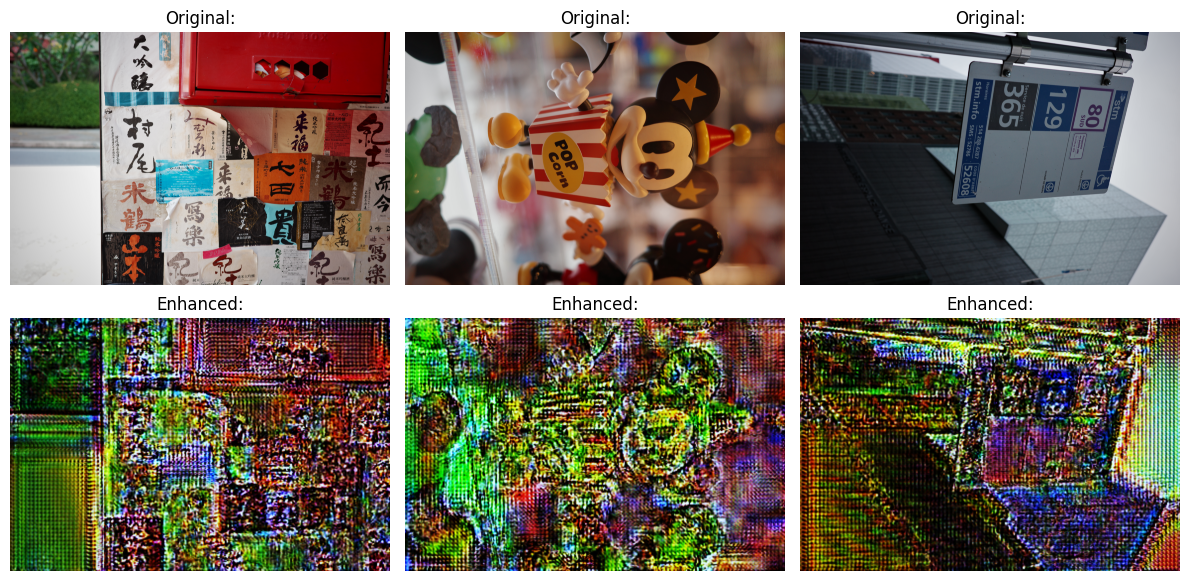

In [11]:
display_before_after_comparison('.', "cyclegan_images", "cyclegan_images_after", image_files)

In [17]:
# Check if processed images are at least HD resolution (1280x720)
import os
from PIL import Image

def check_image_resolution(directory):
    """Check if images in the directory are at least HD resolution (1280x720)"""
    hd_images = []
    non_hd_images = []
    
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(directory, filename)
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    if width >= 1920 and height >= 1080:
                        hd_images.append((filename, width, height))
                    else:
                        non_hd_images.append((filename, width, height))
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    
    return hd_images, non_hd_images

# Check images in the processed directory
hd_images, non_hd_images = check_image_resolution("Processed_image_PNG")

print(f"Found {len(hd_images)} HD images (≥1920x1080)")
print(f"Found {len(non_hd_images)} non-HD images (<1920x1080)")

if non_hd_images:
    print("\nNon-HD images:")
    for name, width, height in non_hd_images:
        print(f"- {name}: {width}x{height}")


Found 15 HD images (≥1920x1080)
Found 0 non-HD images (<1920x1080)


In [16]:
# Save all processed images in PNG format (lossless compression)
import os
from PIL import Image
import shutil

def convert_to_png(source_dir, target_dir=None):
    """
    Convert all images in source_dir to PNG format and save them to target_dir.
    If target_dir is None, images will be saved in the source_dir with PNG extension.
    """
    if target_dir is None:
        target_dir = source_dir
    
    # Create target directory if it doesn't exist
    os.makedirs(target_dir, exist_ok=True)
    
    converted_count = 0
    skipped_count = 0
    
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            try:
                file_path = os.path.join(source_dir, filename)
                with Image.open(file_path) as img:
                    # Create new filename with png extension
                    new_filename = os.path.splitext(filename)[0] + '.png'
                    new_file_path = os.path.join(target_dir, new_filename)
                    
                    # Save as PNG (lossless)
                    img.save(new_file_path, 'PNG')
                    converted_count += 1
                    print(f"Converted: {filename} → {new_filename}")
            except Exception as e:
                print(f"Error converting {filename}: {e}")
        elif filename.lower().endswith('.png'):
            # If it's already PNG, just copy it to target dir if different
            if source_dir != target_dir:
                try:
                    shutil.copy2(
                        os.path.join(source_dir, filename),
                        os.path.join(target_dir, filename)
                    )
                    print(f"Copied: {filename} (already PNG)")
                except Exception as e:
                    print(f"Error copying {filename}: {e}")
            skipped_count += 1
    
    return converted_count, skipped_count

# Convert images in the processed directory to PNG
processed_dir = "Processed_image"
png_dir = "Processed_image_PNG"

converted, skipped = convert_to_png(processed_dir, png_dir)
print(f"\nConversion summary:")
print(f"- {converted} images converted to PNG format")
print(f"- {skipped} images already in PNG format")
print(f"All images saved to: {png_dir}")


Converted: bus_stop_enhance1.jpg → bus_stop_enhance1.png
Converted: bus_stop_enhance2.jpg → bus_stop_enhance2.png
Converted: bus_stop_enhance5.jpg → bus_stop_enhance5.png
Converted: bus_stop_enhance4.jpg → bus_stop_enhance4.png
Converted: basketball_enhanced3.jpg → basketball_enhanced3.png
Converted: mickey_enhance5.jpg → mickey_enhance5.png
Converted: mickey_enhance4.jpg → mickey_enhance4.png
Converted: basketball_enhance1.jpg → basketball_enhance1.png
Converted: mickey_enhance3.jpg → mickey_enhance3.png
Converted: mickey_enhance2.jpg → mickey_enhance2.png
Converted: poster_enhance5.jpg → poster_enhance5.png
Converted: poster_enhance4.jpg → poster_enhance4.png
Converted: poster_enhance3.jpg → poster_enhance3.png
Converted: poster_enhance2.jpg → poster_enhance2.png
Converted: poster_enhance1.jpg → poster_enhance1.png

Conversion summary:
- 15 images converted to PNG format
- 0 images already in PNG format
All images saved to: Processed_image_PNG
